In [104]:
#CONVOLUTION에 후처리 추가.

import numpy as np 

def conv(src,kernel,stride=1,zero_padding=None):
    result=[]

    f_y, f_x= np.shape(src)# 영상의 크기
    print(f_y,f_x)
    k_y, k_x= np.shape(kernel)#커널의 크기
    
    
    #padding이 없다면, 자동으로 이미지 사이즈 유지하도록 설정.
    if zero_padding is None:
        #same padding 만들기위해 패딩 사이즈 계산.
        padding_y = int((stride * f_y-stride-f_y+k_y)/2)
        
        padding_x = int((stride * f_x-stride-f_x+k_x)/2)
        print(padding_y,padding_x)
        
        src = np.pad(src, ((padding_y,padding_y),(padding_x,padding_x)), 'constant', constant_values=0)
    elif zero_padding!=0:
        # 0을 제외하고 zero padding
        padding_y=zero_padding
        padding_x=zero_padding
        src = np.pad(src, ((zero_padding,zero_padding),(zero_padding,zero_padding)), 'constant', constant_values=0)
    else:
        #0일때, 패딩을 주지않는다.
        padding_y=0
        padding_x=0
    print("입력 : \n",src)
    
    #이미지 사이즈 다시 계산
    f_y, f_x= np.shape(src)# 영상의 크기
    #print(f_y,f_x)
    
    #패딩이 생기면 시작점도 달라야한다.
    start_y = padding_y
    start_x = padding_x
    
    if zero_padding !=0:
        #print('y 좌표 최대 ',f_y-padding_y)
        #print('x 좌표 최대 ',f_x-padding_x)
        for y in range(start_y,f_y-padding_y,stride):
            for x in range(start_x,f_x-padding_x,stride):
                result.append((src[y-padding_y:y+k_y-padding_y, x-padding_x:x+k_x-padding_x]* kernel).sum())
        #영상 사이즈는 이전 사이즈 그대로.
        OUTPUT_Y=f_y - 2*padding_y
        OUTPUT_X=f_x - 2*padding_x
                
                
    else:
        #print('y 좌표 최대 ',f_y-k_y+1)
        #print('x 좌표 최대 ',f_x-k_x+1)
        for y in range(start_y,f_y-k_y+1,stride):
            for x in range(start_x,f_x-k_x+1,stride):
                result.append((src[y:y+k_y,x : x+k_x]* kernel).sum())
        #영상 크기 계산
        OUTPUT_Y=int( ((f_y-k_y)/stride)+1 )
        OUTPUT_X=int( ((f_x-k_x)/stride)+1 )
        #print(OUTPUT_Y,OUTPUT_X)
    
    
        
    result=np.array(result).reshape(OUTPUT_Y,OUTPUT_X)
    #후처리( 0보다 작으면 0, 255보다 크면 255)
    result[result<0]=0
    result[result>255]=255
    return result
    
    

305 458
1 1
입력 : 
 [[  0   0   0 ...   0   0   0]
 [  0 234 234 ... 254 253   0]
 [  0 234 234 ... 254 253   0]
 ...
 [  0 210 209 ... 236 236   0]
 [  0 209 210 ... 235 235   0]
 [  0   0   0 ...   0   0   0]]
307 460
y 좌표 최대  306
x 좌표 최대  459


Text(0.5, 1.0, 'self')

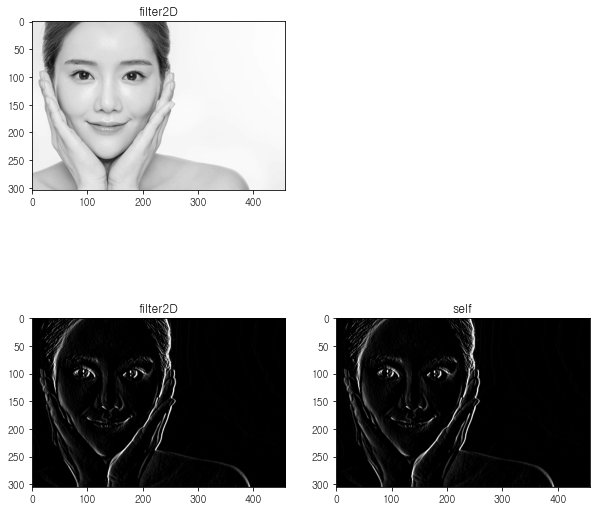

In [97]:
# EX) 소벨 마스크를 이용한 에지 검출. 에지와 관련된 맵들.
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread("../../data/find_face.jpg",0) # gray scale로 읽어서, 1 채널 명암값에 필터를 적용한다.

# 소벨 커널을 직접 생성해서 엣지 검출
## 소벨 커널 생성
gx_k = np.array([[-1,0,1], [-2,0,2],[-1,0,1]])

edge_dx = cv2.filter2D(img, -1, gx_k,borderType=0)
#print("filter 2d 결과 \n",edge_dx)
edge_dx_self = conv(src=img, kernel=gx_k)
#print("결과 \n",edge_dx_self)


fig =plt.figure(figsize=(10,10))

plt.subplot(221)# 1행 2열중 1번째
plt.imshow(img,'gray')
plt.title('filter2D')

plt.subplot(223)# 1행 2열중 1번째
plt.imshow(edge_dx,'gray')
plt.title('filter2D')


plt.subplot(224)# 1행 2열중 1번째
plt.imshow(edge_dx_self,'gray')
plt.title('self')

#결과가 다른 이유는 최대값과 음수에대한 예외처리로 발생.
#255이상은 255로, 음수는 전부 0

## - 가우시안 커널 구현

<img src="https://raw.githubusercontent.com/bub3690/medical_lab_semina/main/%EA%B5%AC%ED%98%84/LogDog/resource/gaussian.PNG" width="450" height="500">

<img src="https://raw.githubusercontent.com/bub3690/medical_lab_semina/main/%EA%B5%AC%ED%98%84/LogDog/resource/gaussian_kernel.PNG" width="550" height="600">

마지막으로 합으로 나눠주면 된다.

커널의 한변 길이는 자동으로 (6시그마) or (6시그마+1)로 설정한다.

---
```
gaussian(sigma)

    - sigma : 표준편차를 넣으면 자동 생성.

```


In [99]:
#ex) 가우시안 필터구현
#https://throwexception.tistory.com/1060
import cv2
from matplotlib import pyplot as plt

def gaussian(sigma):
    #커널 사이즈 할당
    kernel_size = np.around(6*sigma)
    if kernel_size%2 ==0:
        kernel_size=kernel_size+1
    print("커널 사이즈: ",kernel_size,kernel_size)
    a = kernel_size//2
    
    #x,y좌표 생성
    x, y = np.ogrid[-a:a+1, -a:a+1]
    #print(x,y)
    
    #가우시안 식 대입.
    kernel = np.exp(-(y**2+x**2)/(2*sigma**2))# 상수는 제외
    kernel = kernel/np.sum(kernel)
    #print('가우시안 커널 \n',kernel)
    
    return kernel

In [67]:
gaussian(1/2)

커널 사이즈:  3.0 3.0
가우시안 커널 
 [[0.01134374 0.08381951 0.01134374]
 [0.08381951 0.61934703 0.08381951]
 [0.01134374 0.08381951 0.01134374]]


array([[0.01134374, 0.08381951, 0.01134374],
       [0.08381951, 0.61934703, 0.08381951],
       [0.01134374, 0.08381951, 0.01134374]])

커널 사이즈:  37 37
305 458
18 18
입력 : 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
opencv gaussian 결과 
 [[234 234 234 ... 253 253 253]
 [234 234 234 ... 253 253 253]
 [234 234 234 ... 253 253 253]
 ...
 [212 212 212 ... 238 238 238]
 [212 212 212 ... 238 238 238]
 [212 212 212 ... 238 238 237]]
filter 2d 사용시 
 [[ 67  75  83 ...  89  81  72]
 [ 75  84  93 ... 100  91  81]
 [ 83  93 103 ... 111 100  89]
 ...
 [ 75  84  93 ... 104  94  84]
 [ 68  76  84 ...  94  85  76]
 [ 60  68  75 ...  84  76  68]]
self 
 [[ 66.52560892  74.71636658  82.57050845 ...  89.44699959  80.93538508
   72.06031438]
 [ 74.72992721  83.9306287   92.75304663 ... 100.47655977  90.91514127
   80.94547081]
 [ 82.60169694  92.77126972 102.52251334 ... 111.05944094 100.49063804
   89.47061163]
 ...
 [ 74.63448132  83.84319123  92.67474237 ... 104.11746538  94.19632549
   83.85607522]
 [ 67.5362303   75.87284097  83.86950143 ...  94.17853956  85.2

Text(0.5, 1.0, 'self')

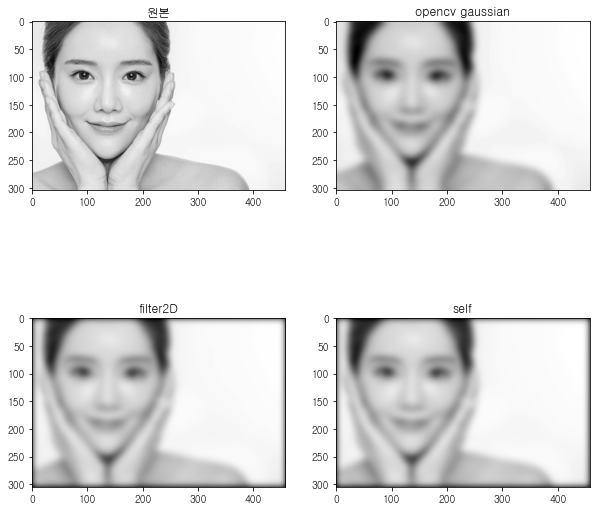

In [112]:
# EX) 가우시안 구현. conv함수, 가우시안, filter2d 비교
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread("../../data/find_face.jpg",0) # gray scale로 읽어서, 1 채널 명암값에 필터를 적용한다.

# 가우시안 커널을 직접 생성
gaussian_k = gaussian(6)


self_img = conv(src=img,kernel=gaussian_k)
gaussian_img = cv2.GaussianBlur(img, (0, 0), 6)
fiter_2d=  cv2.filter2D(img.astype(np.uint8),-1,gaussian_k,borderType=0)
print("opencv gaussian 결과 \n",gaussian_img)
print("filter 2d 사용시 \n", cv2.filter2D(img.astype(np.uint8),-1,gaussian_k,borderType=0))
print("self \n", self_img)

fig =plt.figure(figsize=(10,10))

plt.subplot(221)# 1행 2열중 1번째
plt.imshow(img,'gray')
plt.title('원본')

plt.subplot(222)# 1행 2열중 1번째
plt.imshow(gaussian_img,'gray')
plt.title('opencv gaussian')

plt.subplot(223)# 1행 2열중 1번째
plt.imshow(fiter_2d,'gray')
plt.title('filter2D')

plt.subplot(224)# 1행 2열중 1번째
plt.imshow(self_img,'gray')
plt.title('self')

# 겉 테두리 문제는 padding 차이로 생각
# filter2D와 SELF는 반올림 차이.

## - LOG 필터 (Laplacian of Gaussian)

라플라시안은 이차편도함수를 더한것이다.

<img src="https://raw.githubusercontent.com/bub3690/medical_lab_semina/main/data/laplacian.PNG" width="650" height="700">

영상 f를 가우시안 스무딩하고, 다시 라플라시안을 구한다면 계산 효율이 떨어진다.

또한, 가우시안을 이산 필터로 근사화, 라플라시안을 이산 필터로 근사화 한다. 근사화가 두번되어 오차가 커진다.

그래서, LOG 필터를 사용한다.

<img src="https://raw.githubusercontent.com/bub3690/medical_lab_semina/main/data/logfilter.PNG" width="650" height="700">

컨볼루션과 라플라시안 연산 간 결합법칙이 성립한다.

그래서, 가우시안 커널에 라플라시안을 연산하고, 영상과 컨볼루션 한 것이 LOG 필터이다.


In [141]:
#ex) 라플라시안 가우시안 필터구현
#https://throwexception.tistory.com/1060
import cv2
from matplotlib import pyplot as plt

def laplacian_gaussian(sigma):
    #커널 사이즈 할당
    kernel_size = np.around(6*sigma)
    if kernel_size%2 ==0:
        kernel_size=kernel_size+1
    print("커널 사이즈: ",kernel_size,kernel_size)
    a = kernel_size//2

    
    #x,y좌표 생성
    x, y = np.ogrid[-a:a+1, -a:a+1]
    #print(x,y)
    
    #가우시안 식 대입.
    kernel = ((y**2+x**2)-2*(sigma**2))*np.exp(-(y**2+x**2)/(2*sigma**2))# 상수는 제외
    #라플라시안은 안나눠준다.
    
    return kernel

In [142]:
laplacian_gaussian(1/2)
#중앙이 -로가는 모자모양

커널 사이즈:  3.0 3.0


array([[ 0.02747346,  0.06766764,  0.02747346],
       [ 0.06766764, -0.5       ,  0.06766764],
       [ 0.02747346,  0.06766764,  0.02747346]])

커널 사이즈:  31 31


c:\users\dlwhd\miniconda3\envs\mlstudy\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  import sys


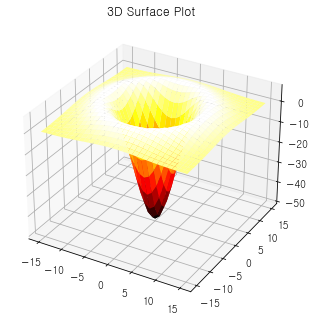

In [152]:
from mpl_toolkits.mplot3d import Axes3D
X = np.arange(-15, 16)
Y = np.arange(-15, 16)
z=laplacian_gaussian(5)
XX, YY = np.meshgrid(X, Y)
fig = plt.figure()
ax = Axes3D(fig)
ax.set_title("3D Surface Plot")
ax.plot_surface(XX, YY, z, rstride=1, cstride=1, cmap='hot')
plt.show()
#시그마 5일때, 맥시칸햇.